# NCAA ML Competition - Women's 2018

## Notes

Notes about what's in the data files: https://www.kaggle.com/c/womens-machine-learning-competition-2018/data

Starter Kernel might help: https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-women-s-dataset

In [100]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

## Load Data

In [101]:
# update this as needed!

# right now, only looking at tournament seed / performance, not regular season games
data_dir = './WDataFiles/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')

In [102]:
# seed = region + seed within region (1-16)
df_seeds.tail(10)

,Season,Seed,TeamID
1270,2017,Z07,3166
1271,2017,Z08,3113
1272,2017,Z09,3277
1273,2017,Z10,3405
1274,2017,Z11,3378
1275,2017,Z12,3346
1276,2017,Z13,3195
1277,2017,Z14,3442
1278,2017,Z15,3253
1279,2017,Z16,3421


In [103]:
# contains winning and losing team IDs (must check against list of teams)
# winning and losing team scores
# WLoc = home (H), away (A), neutral (N)
df_tour.tail(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1250,2017,145,3199,66,3333,53,N,0
1251,2017,145,3332,77,3268,63,N,0
1252,2017,145,3376,100,3346,58,N,0
1253,2017,146,3280,94,3124,85,N,1
1254,2017,146,3390,76,3323,75,N,0
1255,2017,147,3163,90,3332,52,H,0
1256,2017,147,3376,71,3199,64,N,0
1257,2017,151,3280,66,3163,64,N,1
1258,2017,151,3376,62,3390,53,N,0
1259,2017,153,3376,67,3280,55,N,0


## Merge

In [104]:
# merge seeds with team IDs for tourney performance
df_W = df_seeds.rename(columns={'TeamID':'WTeamID', 'Seed':'WSeed'})
df_L = df_seeds.rename(columns={'TeamID':'LTeamID', 'Seed':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_W, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_L, on=['Season', 'LTeamID'])

# at the beginning of the tourney, teams play within their region
# final 3 games = between regions
df_concat.tail(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed
1250,2017,145,3199,66,3333,53,N,0,Z03,Z02
1251,2017,145,3332,77,3268,63,N,0,W10,W03
1252,2017,145,3376,100,3346,58,N,0,Z01,Z12
1253,2017,146,3280,94,3124,85,N,1,X02,X01
1254,2017,146,3390,76,3323,75,N,0,Y02,Y01
1255,2017,147,3163,90,3332,52,H,0,W01,W10
1256,2017,147,3376,71,3199,64,N,0,Z01,Z03
1257,2017,151,3280,66,3163,64,N,1,X02,W01
1258,2017,151,3376,62,3390,53,N,0,Z01,Y02
1259,2017,153,3376,67,3280,55,N,0,Z01,X02


In [105]:
# calculate seed differential: positive = higher seed won, negative = lower seed won
df_concat['SeedDiff'] = df_concat.apply(lambda row: int(row['LSeed'][1:3]) - int(row['WSeed'][1:3]), axis=1)

df_concat.tail(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,SeedDiff
1250,2017,145,3199,66,3333,53,N,0,Z03,Z02,-1
1251,2017,145,3332,77,3268,63,N,0,W10,W03,-7
1252,2017,145,3376,100,3346,58,N,0,Z01,Z12,11
1253,2017,146,3280,94,3124,85,N,1,X02,X01,-1
1254,2017,146,3390,76,3323,75,N,0,Y02,Y01,-1
1255,2017,147,3163,90,3332,52,H,0,W01,W10,9
1256,2017,147,3376,71,3199,64,N,0,Z01,Z03,2
1257,2017,151,3280,66,3163,64,N,1,X02,W01,-1
1258,2017,151,3376,62,3390,53,N,0,Z01,Y02,1
1259,2017,153,3376,67,3280,55,N,0,Z01,X02,1


In [106]:
# Baseline: just use seed information? 
# Baseline: 50/50 chance? (even easier)

In [107]:
# Stage 1: submission file
# Make predictions for all possible matchups from the past four NCAA® tournaments 2014-2017
# (64*63/2 = 2,016 predictions per year)
recent_tourney_teams = df_seeds = df_seeds[df_seeds['Season'] > 2013]
recent_tourney_teams = recent_tourney_teams.reset_index(drop=True)
recent_tourney_teams.head(10)

# how to match these up pairwise each year??

# ID - string SSSS_XXXX_YYYY, SSSS = 4-digit season yr, 
# XXXX  = 4-digit TeamID of lower-ID team, YYYY = 4-digit TeamID of higher-ID team.
# Pred - predicted winning percentage for the first team in the ID field

,Season,Seed,TeamID
0,2014,W01,3163
1,2014,W02,3181
2,2014,W03,3401
3,2014,W04,3304
4,2014,W05,3301
5,2014,W06,3211
6,2014,W07,3177
7,2014,W08,3208
8,2014,W09,3386
9,2014,W10,3328


In [108]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,13,1
1,11,1
2,13,1
3,3,1
4,-3,1


In [109]:
## Create training and test data sets; may create a dev dataset later
num_test = len(df_predictions)

mask = np.random.rand(len(df_predictions)) < 0.8 ## 80% data for training and 20% for testing
train_data = df_predictions[mask]
test_data = df_predictions[~mask]

#test_data, test_labels = df_predictions.data[num_test/2:], newsgroups_test.target[num_test/2:]
#dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
#train_data, train_labels = newsgroups_train.data, newsgroups_train.target


In [110]:
## Convert to arrays
X_train = train_data.SeedDiff.values.reshape(-1,1)
y_train = train_data.Result.values
X_test = test_data.SeedDiff.values.reshape(-1,1)
y_test = test_data.Result.values

In [111]:
## Fit a logistic regression model through grid search
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.4443, with best C: 0.1


Text(0,0.5,u'P(Team1 will win)')

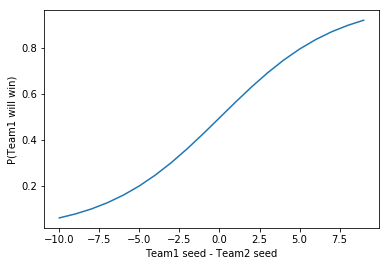

In [112]:
## Plot to confirm intuition that greater positive seed difference indicates higher win probability
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

In [113]:
df_sample_sub = pd.read_csv(data_dir + 'WSampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))


In [114]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label


In [115]:
## Unpack the ID field for team IDs
## Look up seeds for the team
## Calculate seed difference

X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed


In [117]:
## Make predictions

preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,ID,Pred
0,2014_3103_3107,0.361547
1,2014_3103_3113,0.747181
2,2014_3103_3119,0.495527
3,2014_3103_3124,0.950000
4,2014_3103_3140,0.564019
